In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
Instead of downloading images with Bing Image Search, I will be using Duck Duck Go.

In [5]:
??search_images_ddg

As the time of writting this, the provided function throws some error at
```python
    res = urlread(url,data={'q':term}).decode()
```
A working function definition overwrites it, as explained in https://forums.fast.ai/t/duck-duck-go-code-not-working/85287/2

In [7]:
def search_images_ddg(key,max_n=200):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
       (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [8]:
ims = search_images_ddg('grizzly bear')
len(ims)

186

In [9]:
ims[0]

'https://holidayarchitects.co.uk/canada-holidays/wp-content/uploads/sites/7/Grizzly-bear-3-CRWW.jpg'

In [10]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

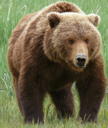

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

It's working!

#### I will be developing a climbing image classifier

In [14]:
main_subject = 'climbing'
climbing_types = 'ice','indoor','outdoor rock'
path = Path(main_subject)

In [17]:
if not path.exists():
    path.mkdir()
    for o in climbing_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} {main_subject}', 500)
        print(results[0])    # just for debugging
        download_images(dest, urls=results)

http://chillupguide.com/wp-content/uploads/2013/12/FI-rjukan.jpg
https://www.lydiascapes.com/wp-content/uploads/2018/03/Urban-Playground.jpg
https://www.altitude-activities.com/wp-content/uploads/2019/01/Rock-climbing-kindergarden-Slovenia.jpg


In [18]:
fns = get_image_files(path)
fns

(#1217) [Path('climbing/ice/00000376.jpg'),Path('climbing/ice/00000280.jpg'),Path('climbing/ice/00000047.jpg'),Path('climbing/ice/00000392.jpg'),Path('climbing/ice/00000379.JPG'),Path('climbing/ice/00000199.jpg'),Path('climbing/ice/00000237.jpg'),Path('climbing/ice/00000055.jpg'),Path('climbing/ice/00000356.jpg'),Path('climbing/ice/00000183.jpg')...]

In [19]:
doc(type(fns))

In [20]:
failed = verify_images(fns)
failed

(#13) [Path('climbing/ice/00000192.jpg'),Path('climbing/ice/00000270.jpg'),Path('climbing/ice/00000271.jpg'),Path('climbing/ice/00000111.jpg'),Path('climbing/outdoor rock/00000134.jpg'),Path('climbing/outdoor rock/00000459.jpg'),Path('climbing/outdoor rock/00000016.jpg'),Path('climbing/outdoor rock/00000310.jpg'),Path('climbing/outdoor rock/00000245.jpg'),Path('climbing/indoor/00000427.jpg')...]

In [21]:
failed.map(Path.unlink);

In [22]:
fns = get_image_files(path)
fns

(#1204) [Path('climbing/ice/00000376.jpg'),Path('climbing/ice/00000280.jpg'),Path('climbing/ice/00000047.jpg'),Path('climbing/ice/00000392.jpg'),Path('climbing/ice/00000379.JPG'),Path('climbing/ice/00000199.jpg'),Path('climbing/ice/00000237.jpg'),Path('climbing/ice/00000055.jpg'),Path('climbing/ice/00000356.jpg'),Path('climbing/ice/00000183.jpg')...]

Transparency will be throwing a warning, so I previously remove alpha channel when encountered

In [23]:
def depalettize_images(fns):
    for image in fns:
        palette2rgba(image)

def palette2rgba(image):
    # convert image to RGBA
    im = Image.open(image)
    if im.mode == 'P':
        im.convert("RGB").save(f"{image}")

In [24]:
depalettize_images(fns)

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [25]:
climbing = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [26]:
??parent_label

In [27]:
??get_image_files

In [28]:
dls = climbing.dataloaders(path)

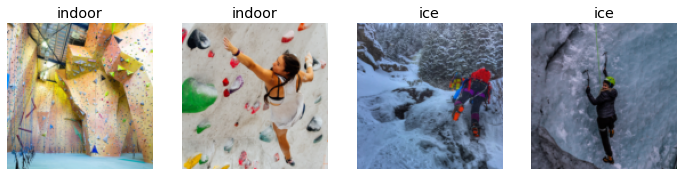

In [29]:
dls.valid.show_batch(max_n=4, nrows=1)

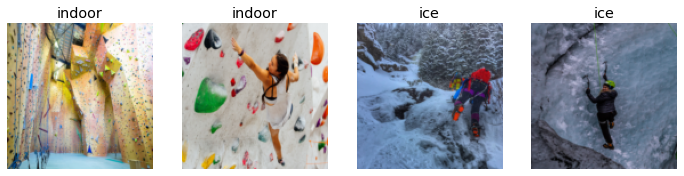

In [31]:
climbing = climbing.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = climbing.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [32]:
doc(Resize)

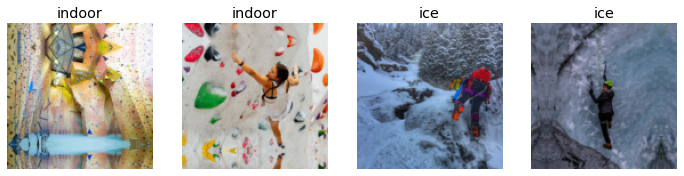

In [33]:
climbing = climbing.new(item_tfms=Resize(128, ResizeMethod.Pad))
dls = climbing.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

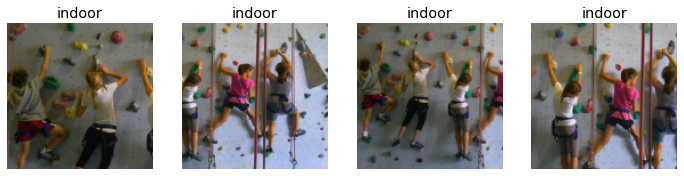

In [38]:
climbing = climbing.new(item_tfms=RandomResizedCrop(128, min_scale=0.2))
dls = climbing.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

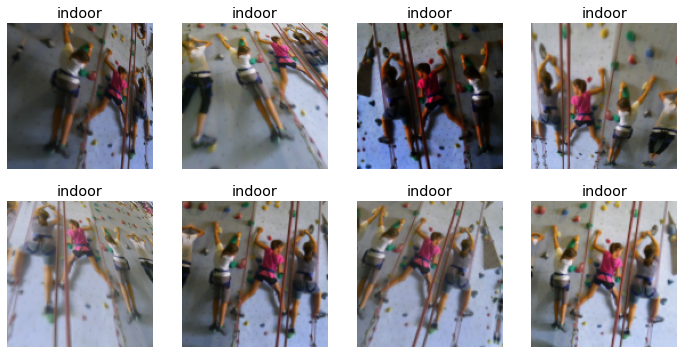

In [41]:
climbing = climbing.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = climbing.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [39]:
doc(aug_transforms)

## Training Your Model, and Using It to Clean Your Data

In [54]:
climbing = climbing.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = climbing.dataloaders(path)

In [55]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.024419,0.364660,0.062500,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.414916,0.342453,0.083333,00:20
1,0.334709,0.375511,0.075000,00:20
2,0.280871,0.335291,0.075000,00:21
3,0.227278,0.323228,0.075000,00:21


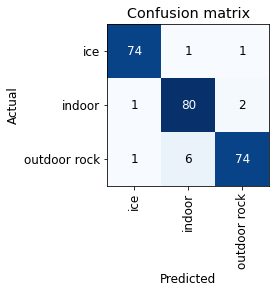

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

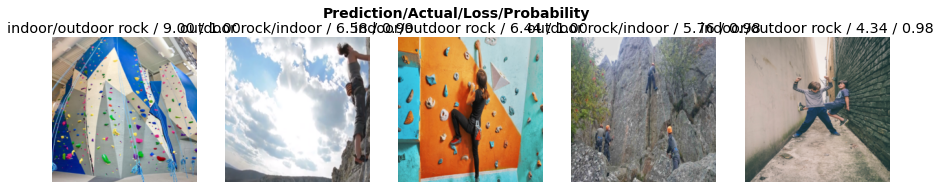

In [45]:
interp.plot_top_losses(5, nrows=1)

### In the next two cells, I clean and fix some wrong labels
It must be done by rows. That is, for each category and dataset, mark the wrong images and then apply those changes **before** switching to ther category or dataset.

In [65]:
cleaner = ImageClassifierCleaner(learn, height=256)
cleaner

In [76]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
    src = cleaner.fns[idx]
    filename = src.name
    new_filename = 'm' + filename     # In order to avoid overwrite issues
    shutil.move(str(src), path/cat/new_filename)

Now, retrain the model with the cleaned dataset

In [77]:
dls = climbing.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.959947,0.139863,0.046414,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.188822,0.099824,0.037975,00:20
1,0.141363,0.096958,0.025316,00:22
2,0.107722,0.091746,0.016878,00:21
3,0.103000,0.099491,0.021097,00:21


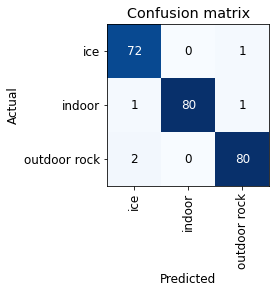

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

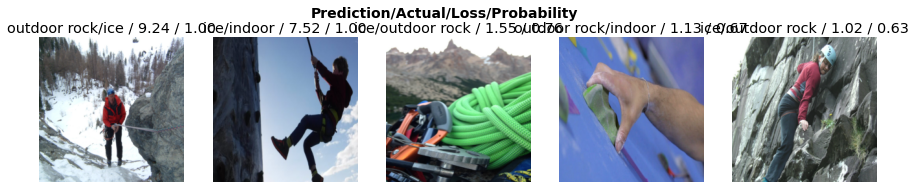

In [79]:
interp.plot_top_losses(5, nrows=1)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [80]:
learn.export()

In [81]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [110]:
??path.ls

In [82]:
learn_inf = load_learner(path/'export.pkl')

In [83]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

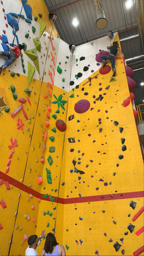

In [93]:
img = PILImage.create(uploader.data[0])
img.to_thumb(256)

In [94]:
learn_inf.predict(img)

('indoor', tensor(1), tensor([8.0082e-06, 9.9997e-01, 2.0823e-05]))

In [90]:
learn_inf.dls.vocab

['ice', 'indoor', 'outdoor rock']

### Creating a Notebook App from the Model

In [95]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [97]:
img = PILImage.create(btn_upload.data[-1])

In [107]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(512,512))
out_pl

Output()

In [99]:
pred,pred_idx,probs = learn_inf.predict(img)

In [106]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.02%}'
lbl_pred

Label(value='Prediction: outdoor rock; Probability: 99.97%')

In [101]:
type(pred_idx)

torch.Tensor

In [102]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [108]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256,256))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.02%}'

btn_run.on_click(on_click_classify)

In [109]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

##### Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
The example provided in the notebook was a realtime video feed application. The training data we provided to the system consisted on full frame pictures of bears, as they are pictures shown when searching for that query. If we were test our system on frames from a surveilance camera, bears will probably appear partially hidden and certanly not full framed. So this model could probably not be used to detect bears with images from a surveilance camera.

##### Where do text models currently have a major deficiency?
Text models are not good at generating meaningful texts. They can generate coherent and apparently good written content, but lack the ability to rationalize these responses. This is probably due to the architecture used in this field. Usually previous words are the seed that generates the next one, so the so call memory is mostly short sighted.

##### What are possible negative societal implications of text generation models?
It is possible that this technology could be used massively to spread disinformation in social media.

##### In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
Always keep a well trained person watching out for the model and its performance.

##### What kind of tabular data is deep learning particularly good at?
It increases the variety of columns that can be included in training. (Natural language, high-cardinality categorical variables...)

##### What's a key downside of directly using a deep learning model for recommendation systems?
I will probably recommend the user products that he would like, but already knows. For example, books of the same author. As of now, a recommendation system is not able to discover new titles with the expertise of a librarian.

##### What are the steps of the Drivetrain Approach?
Define objetive > Consider accions that can be taken > Think about what data could be useful > Build a model to determine what actions are best for the initial objetive

##### How do the steps of the Drivetrain Approach map to a recommendation system?
The objetive is to increase sales (obviously). The action is showing certain recommendations to the users. The data (and this is where most recommendation systems fail) should be collected by doing random experiments that give new information, in addition to traditional similar users correlation.

##### Create an image recognition model using data you curate, and deploy it on the web.
Done, saved in [simple_climbing_classifier](../sandbox/simple_climbing_classifier.ipynb)

##### What is `DataLoaders`?
It is a thin class that by default stores train and validation `DataLoader`s. A `DataLoader` is an iterable that wraps a `Dataset` and allows easy access to the data itself (in batches).

##### What four things do we need to tell fastai to create `DataLoaders`?
- What kind of data we are dealing with
- How to get this data
- How to get the labels
- How to create de validation set

##### What does the `splitter` parameter to `DataBlock` do?
It specifies how to create the validation set. A predefined class can be used, or a custom one.

##### How do we ensure a random split always gives the same validation set?
By setting a `seed` that initializes the pseudo-random number generator.

##### What letters are often used to signify the independent and dependent variables?
`x` is the **independent** variable or input.

`y` is the **dependent** variable or expected output (ground truth).

##### What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
**Crop** removes the excess image to match the desired size. It preserves aspect ratio. Probably best used when classifiying patterns such as mountain vs beach photos.

**Pad** fills the image to match the size requested. It can be filled with zeroes (black background) but usually better performance is achieved if a reflection is used. It also preserves aspect ratio. The main drawback of this method is the inefficiency, so it could be used as long as computation power is not an issue.

**Squish** losses the original aspect ratio in order to preserve the the full original image by streaching it. It could be useful when we know beforehand that input images aspect ratio are nearly equal to the desired one.

The best method, however, is any of the above. **Random cropping** images on each epoch gives the bests results, as it allows the model to focus on different part of the images and provides a better approximation to real world images that could be framed differently.

##### What is data augmentation? Why is it needed?
**Data augmentation** is kind of the next step to random cropping. It consists of creating random variations of the input data such as rotation, changes in perspective, brightness, 

##### What is the difference between `item_tfms` and `batch_tfms`?
`item_tfms` is done in **CPU**. Resizing and cropping must be done in CPU as the data must be prepared and resized prior to GPU batch processing (which is faster). `batch_tfms` is done in **GPU** in a much faster way.

##### What is a confusion matrix?
It is a compact representation of the model's performance. It counts hits and misses for each combination of category.

##### What does `export` save?
`export` function saves the architecture, as well as the trained parameters. This could be enough, but the definition of how to create `DataLoaders` is also saved, which eases the future use of the model in production.

##### What is it called when we use a model for getting predictions, instead of training?
Doing inference.

##### What are IPython widgets?
IPython widgets are easy to configure GUI (graphical user interface) components than can be used in a Jupyter notebook.

##### When might you want to use CPU for deployment? When might GPU be better?
Almost every time, a CPU will be enough. GPUs are necessary for training the model, but predicting single results take no advantage of the parallelization power of GPUs. Nevertheless, if an application is used massively, GPU usage could become interesting, as several inferences could be batched and feeded to a GPU.

##### What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
The most important of all is network dependency. If there is no network connection available, the client app will not work. Another issue to take into consideration is latency that could impact the user experience.

##### What are three examples of problems that could occur when rolling out a bear warning system in practice?
As exposed in a previous answer, if the data feeded into the model is bastly different from the training data (for example, a security camera footage) the model will struggle to classify correctly a bear in the picture. The bear could be partially hiddel behind a bush, in a poor light condition or facing away from the camara. As none of these cases were used in the training phase, it is very hard for the model to perform correctly.

It could also perform well but slowly for that use case.

Another problem could be nighttime photos not being properly classify, despite depicting a full frame bear facing the camera.

##### What is "out-of-domain data"?
The problems exposed with the bear warning system are an example of _out-of-domain data_. The model sees images that have no resemblance with the ones used for training.

##### What is "domain shift"?
_Domain shift_ occurs when the model is accurately tuned for the data that can be encountered today in the real world, but time passes and the world changes. If the model is not updated, its performance will degrade. An example could be autonomous driving. If a model is trained with dashcam video from several year ago and today it encounters an electric scooter, it won't be able to classify it correctly and it's possible that the system behaves in an unpredicted way.

##### What are the three steps in the deployment process?
- **Manual process**, with humans checking all the precitions.
- **Limited scope deployment**, where the consecuences can be controlled.
- **Gradual expansion**. With good reporting systems.

### Further Research

##### Consider how the Drivetrain Approach maps to a project or problem you're interested in.


##### When might it be best to avoid certain types of data augmentation?
In CNNs where the images don't correspond to real world photos, data augmentation could result in worse model performance. E.g. audio analysis with fourier transforms.

##### For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"


##### Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.